In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
# load data
random_state=42
best_models = {}

data = pd.read_csv(r'C:\Users\Admin\Desktop\Skin_Cancer\Data\Final_skin_cancer.csv')
data.drop('drink', axis=1, inplace=True)


In [3]:
data.duplicated().sum()

856

In [4]:
#drop duplicates
data.drop_duplicates(inplace=True)

In [5]:
data.duplicated().sum()

0

In [17]:
# data.drop(['fitspatrick','region_hash_0','region_hash_1','region_hash_2','region_hash_3','region_hash_4','region_hash_5','region_hash_6','region_hash_7','region_hash_8','region_hash_9','changed','bleed','elevation','biopsed','diameter_2','diameter_1','itch','grew','hurt'], axis=1, inplace=True)

In [18]:
# data

In [6]:
from sklearn.model_selection import train_test_split

def splitting_data(df, sampling, test_size=0.2, random_state=123):
    # First, split the data into features and target variable
    X = df.drop(['diagnostic'], axis=1)
    y = df['diagnostic']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Apply sampling methods to the training data based on the specified method
    if sampling == 'none':
        return X_train, X_test, y_train, y_test
    elif sampling == 'SMOTEENN':
        from imblearn.combine import SMOTEENN
        smote_enn = SMOTEENN(random_state=random_state)
        X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'SMOTE':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'under':
        from imblearn.under_sampling import RandomUnderSampler
        rus = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test
    elif sampling == 'over':
        from imblearn.over_sampling import RandomOverSampler
        rus = RandomOverSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        return X_resampled, X_test, y_resampled, y_test


In [7]:

def training(X_train, y_train):

    HGB = HistGradientBoostingClassifier()
    # Fit the classifier to the data
    HGB.fit(X_train, y_train)
    return HGB

In [8]:
def best_model(modelName, accuracy, precision, recall, f1):
    best_models[modelName] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [9]:
def predict(modleName,HGB, X_test ,y_test):
    # Predict the labels for the training data X
    y_pred = HGB.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cr=classification_report(y_test, y_pred)
    print(cr)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

def optimize_with_grid(X_train, y_train):

    # Initialize the LGBMClassifier
    HGB = HistGradientBoostingClassifier()
    # Define the parameter grid
    param_grid = {
        'max_iter': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_samples_leaf': [20, 40, 60]
    }

    # Initialize GridSearchCV
    HGB_cv = GridSearchCV(HGB, param_grid, cv=5)

    # Fit the grid search to the data
    HGB_cv.fit(X_train, y_train)

    # Best parameters and best score
    best_params = HGB_cv.best_params_
    best_score = HGB_cv.best_score_
    best_estimator = HGB_cv.best_estimator_
    print(best_params)
    print(best_score)

    return best_estimator

# Original Dataset

In [11]:
# using function with no sampling
X_train, X_test, y_train, y_test = splitting_data(data, 'none')
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
#check number of observations in each class in the set
print("Number of observations in each class in the training set:")
print(y_train.value_counts())

Number of observations in each class in the training set:
diagnostic
1    565
0    114
Name: count, dtype: int64


In [13]:
HGB1 = training(X_train, y_train)
y_pred = predict('original',HGB1, X_test, y_test)

              precision    recall  f1-score   support

           0       0.68      0.60      0.64        25
           1       0.93      0.95      0.94       145

    accuracy                           0.90       170
   macro avg       0.81      0.78      0.79       170
weighted avg       0.90      0.90      0.90       170



In [14]:
best_HGB1 = optimize_with_grid(X_train, y_train)
prediction = predict('original_grid',best_HGB1, X_test, y_test)

{'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 40}
0.9086601307189544
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        25
           1       0.94      0.95      0.95       145

    accuracy                           0.91       170
   macro avg       0.82      0.80      0.81       170
weighted avg       0.90      0.91      0.90       170



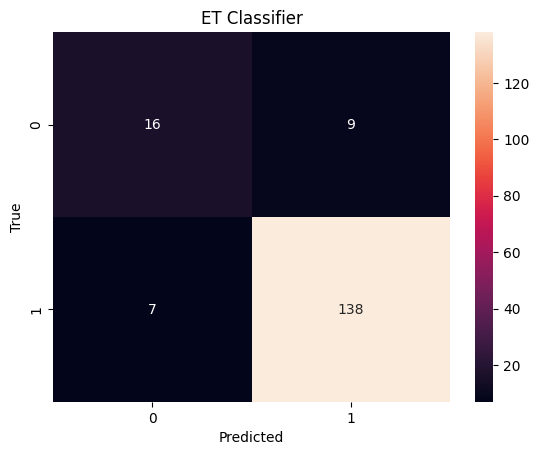

In [15]:
from sklearn.metrics import confusion_matrix
# plot the confusion matrix for the model

y_pred = best_HGB1.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ET Classifier')
plt.show()